#STEP #1 - Set the seed

In [0]:
# Seed value
seed_value= 0
 
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
 
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
 
# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
 
# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
 
# 5. Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

#STEP #2 - Import the necessary 

In [2]:
import tensorflow as tf
import tensorflow.keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Flatten,Dense,Activation,Dropout,MaxPooling2D
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import csv

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#STEP #3 - Data preprocessing

In [0]:
# the path to the dataset.csv file
path = '/content/drive/My Drive/Colab Notebooks/Open-closed eye classifier/dataset.csv'

# dimensions of the photos
height = 26
width = 34
dims = 1

# scaler used for normalizing the dataset
scaler = MinMaxScaler()

In [0]:
with open(path,'r') as f:
		# read the csv file with the dictionary format 
		reader = csv.DictReader(f)
		rows = list(reader)

# imgs is a numpy array with all the images
# tgs is a numpy array with the tags of the images
imgs = np.empty((len(list(rows)),height,width, dims),dtype=np.float32)
tgs = np.empty((len(list(rows)),1))
  
for row, i in zip(rows, range(len(rows))):
  
  # convert the list back to the image format
  img = row['image']
  img = img.strip('[').strip(']').split(', ')
  im = np.array(img,dtype=np.float32)

  im = im.reshape((26,34))

  # normalize the data
  im = scaler.fit_transform(im)

  im = np.expand_dims(im, axis=2)
  imgs[i] = im

  # the tag for open eye is 1 and for close eye is 0
  tag = row['state']
  if tag == 'open':
    tgs[i] = 1
  else:
    tgs[i] = 0

# shuffle the dataset
index = np.random.permutation(imgs.shape[0])
imgs = imgs[index]
tgs = tgs[index]

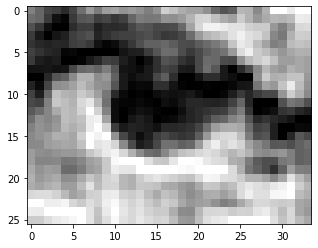

In [5]:
# visualize one image 
plt.imshow(imgs[213][:,:,-1], cmap='gray')

In [0]:
# Splitting the dataset into training, validation and testing
# X stands for the column 'image' and y stands for the column 'state' from the original dataset
X_train, X_test, y_train, y_test = train_test_split(imgs, tgs, test_size=0.20, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

In [6]:
# print the shape of the sets
print('X_train shape = ', X_train.shape)
print('y_train shape = ', y_train.shape)

print('X_validation shape = ', X_val.shape)
print('y_validation shape = ', y_val.shape)

print('X_test shape = ', X_test.shape)
print('y_test shape = ', y_test.shape)

X_train shape =  (2299, 26, 34, 1)
y_train shape =  (2299, 1)
X_validation shape =  (288, 26, 34, 1)
y_validation shape =  (288, 1)
X_test shape =  (287, 26, 34, 1)
y_test shape =  (287, 1)


#STEP #4 - Online data augumentation

In [0]:
data_generator = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        )
data_generator.fit(X_train)
data_generator.fit(X_val)

#STEP #5 - Set parameters

In [0]:
NUMBER_OF_EPOCHS = 50
BATCH_SIZE = 32
STEPS_PER_EPOCH = len(X_train) / 32
STEPS_PER_VALIDATION = len(X_val) / 32

verbosity = 1
loss_function = 'binary_crossentropy'
learning_rate = 0.001
threshold = 0.5

#STEP #6 - Model architecture

In [0]:
# convolution = feature detection
# ReLU adds non-liniarity and improves the model
# pooling = compress feature detectors

model = Sequential()

# first layer of convolution
model.add(Conv2D(32, kernel_size=(3,3), padding = 'same', activation='relu', input_shape=(height, width, dims)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# second layer of convolution
model.add(Conv2D(64, kernel_size=(3,3), padding= 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# third layer of convolution
model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# drops some neurons along with their weights to avoid overfitting
model.add(Dropout(0.25))

model.add(Flatten())

# first dense layer
model.add(Dense(512))
model.add(Activation('relu'))

# second dense layer
model.add(Dense(512))
model.add(Activation('relu'))

# output layer
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(optimizer = Adam(lr = learning_rate), loss = loss_function, metrics = ['accuracy'])

In [12]:
# overview on the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 34, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 17, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 4, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 4, 128)         0

#STEP #7 - Train the model

In [13]:
#train the model
history = model.fit(data_generator.flow(X_train, y_train, batch_size = BATCH_SIZE),steps_per_epoch = STEPS_PER_EPOCH, 
                    validation_steps = STEPS_PER_VALIDATION, validation_data = data_generator.flow(X_val, y_val, batch_size = BATCH_SIZE),
                    epochs = NUMBER_OF_EPOCHS)

Epoch 1/50
72/71 [==============================] - 1s 18ms/step - loss: 0.4398 - accuracy: 0.7999 - val_loss: 0.2200 - val_accuracy: 0.9167
Epoch 2/50
72/71 [==============================] - 1s 15ms/step - loss: 0.1623 - accuracy: 0.9378 - val_loss: 0.1300 - val_accuracy: 0.9688
Epoch 3/50
72/71 [==============================] - 1s 15ms/step - loss: 0.1201 - accuracy: 0.9565 - val_loss: 0.1310 - val_accuracy: 0.9583
Epoch 4/50
72/71 [==============================] - 1s 15ms/step - loss: 0.0900 - accuracy: 0.9687 - val_loss: 0.1100 - val_accuracy: 0.9583
Epoch 5/50
72/71 [==============================] - 1s 15ms/step - loss: 0.0846 - accuracy: 0.9700 - val_loss: 0.0804 - val_accuracy: 0.9792
Epoch 6/50
72/71 [==============================] - 1s 16ms/step - loss: 0.0635 - accuracy: 0.9774 - val_loss: 0.1085 - val_accuracy: 0.9688
Epoch 7/50
72/71 [==============================] - 1s 16ms/step - loss: 0.0594 - accuracy: 0.9817 - val_loss: 0.0784 - val_accuracy: 0.9792
Epoch 8/50
72

#STEP #8 - Evaluate the model

In [14]:
loss, acc = model.evaluate(X_test, y_test, batch_size = BATCH_SIZE, verbose = verbosity)

9/9 [==============================] - 0s 4ms/step - loss: 0.0621 - accuracy: 0.9861


In [0]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

In [0]:
def plot_metric(x,y1,y2,color1,color2,label1,label2, title):
  plt.subplots(figsize=(20,8))
  
  plt.plot(x, y1, 'b', label=label1, color=color1)
  plt.plot(x, y2, 'b', label=label2, color=color2)
  plt.title(title)
  plt.legend()

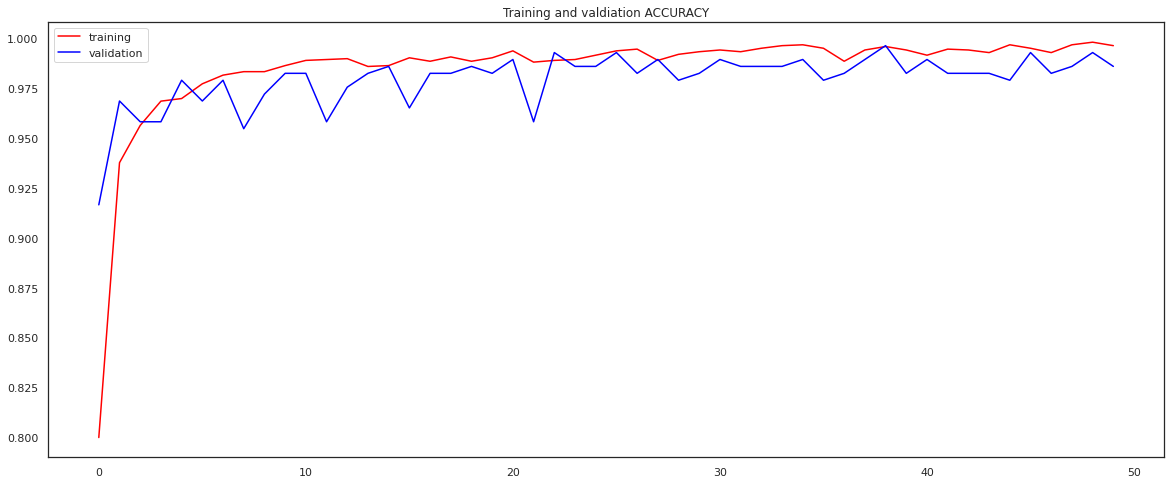

In [17]:
epochs = range(len(training_accuracy))
sns.set(style="white")
plot_metric(epochs, training_accuracy, validation_accuracy, 'red','blue','training','validation', 'Training and valdiation ACCURACY')

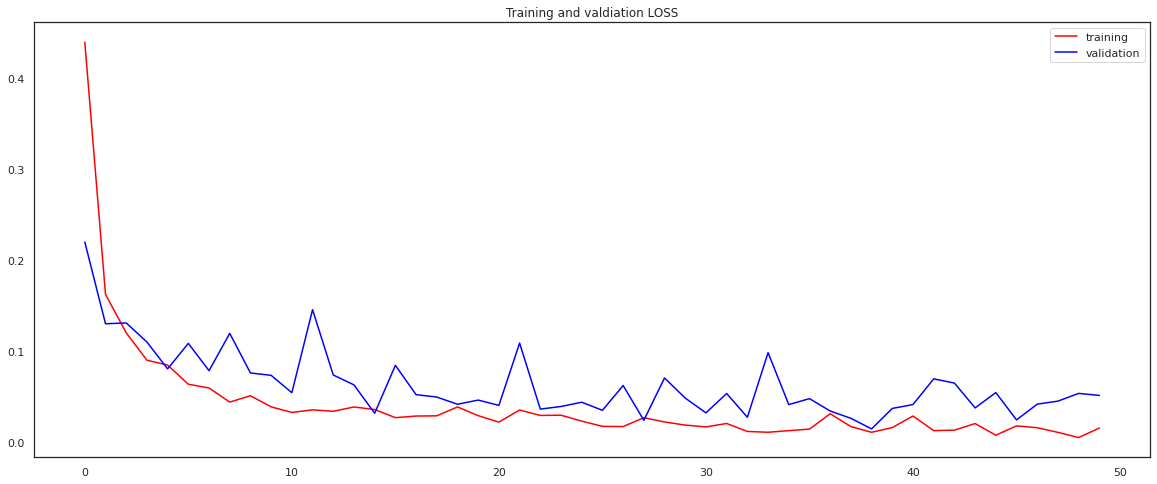

In [18]:
epochs = range(len(training_accuracy))
plot_metric(epochs, training_loss, validation_loss, 'red','blue','training','validation', 'Training and valdiation LOSS')

In [0]:
# make prediction over test data
y_pred = model.predict(X_test)

# transform y_pred using threshold
y_pred = (y_pred > threshold)

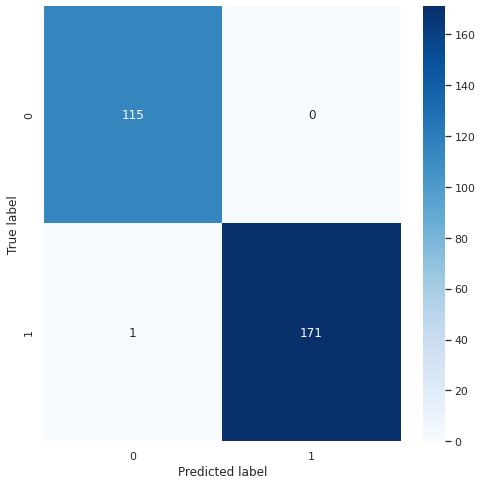

In [81]:
# build confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot = True, cmap = plt.cm.Blues, fmt = "d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [82]:
# overview on precision and recall
class_names = ['Open', 'Close']
print(classification_report(y_test, y_pred, target_names = class_names))

              precision    recall  f1-score   support

        Open       0.99      1.00      1.00       115
       Close       1.00      0.99      1.00       172

    accuracy                           1.00       287
   macro avg       1.00      1.00      1.00       287
weighted avg       1.00      1.00      1.00       287



In [0]:
# make prediction over all data
y_pred_all = model.predict(imgs)

# transform y_pred using threshold
y_pred_all = (y_pred_all > threshold)

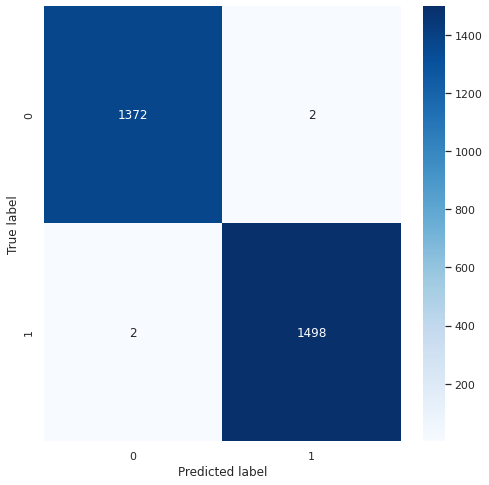

In [84]:
# build confusion matrix
conf_matrix = confusion_matrix(tgs, y_pred_all)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot = True, cmap = plt.cm.Blues, fmt = "d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#STEP #9 - Save the model

In [0]:
# the path and name of the model
path = '/content/drive/My Drive/eyeClassifier_v6.hdf5' 
model.save(path)

#STEP #10 - Convert the model to TFLite

In [32]:
model.save('/content/drive/My Drive/eyeClassifier_v6_tflite')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/eyeClassifier_v6_tflite/assets


In [0]:
converter = tf.lite.TFLiteConverter.from_saved_model('/content/drive/My Drive/eyeClassifier_v6_tflite')
tflite_model = converter.convert()

In [34]:
open("/content/drive/My Drive/eyesClassifier_v6.tflite", "wb").write(tflite_model)

4574784

#STEP #11 - TFLite Inference

In [0]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/content/drive/My Drive/eyesClassifier_v6.tflite")
interpreter.allocate_tensors()

In [0]:
# make prediction with .hdf5 model over all data
y_pred = model.predict(X_test)

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# make prediction with .tflite model over all data
y_pred_tflite = []
for i in X_test:

  # add one more axis
  i = i[np.newaxis,:,:]

  interpreter.set_tensor(input_details[0]['index'], i)
  interpreter.invoke()
  output_data = interpreter.get_tensor(output_details[0]['index'])
  y_pred_tflite.append(output_data)

In [0]:
y_pred_tflite = np.asarray(y_pred_tflite)

In [87]:
y_pred.shape

(287, 1)

In [88]:
y_pred_tflite.shape

(287, 1, 1)

In [89]:
# transform y_pred using threshold
y_pred = (y_pred > 0.5)

# visualize y_pred after transformation
y_pred

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [

In [90]:
# transform y_pred using threshold
y_pred_tflite = (y_pred > 0.5)

# visualize y_pred after transformation
y_pred_tflite

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [

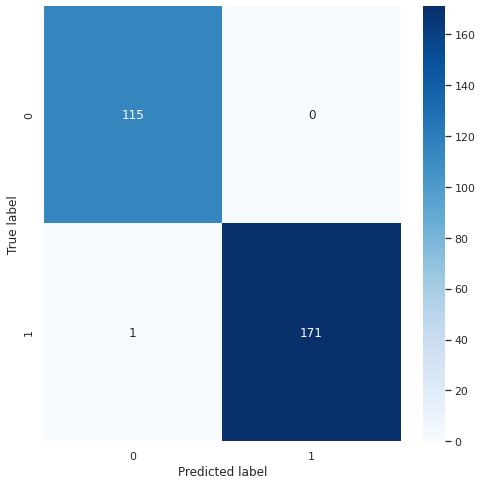

In [91]:
# build confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot = True, cmap = plt.cm.Blues, fmt = "d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

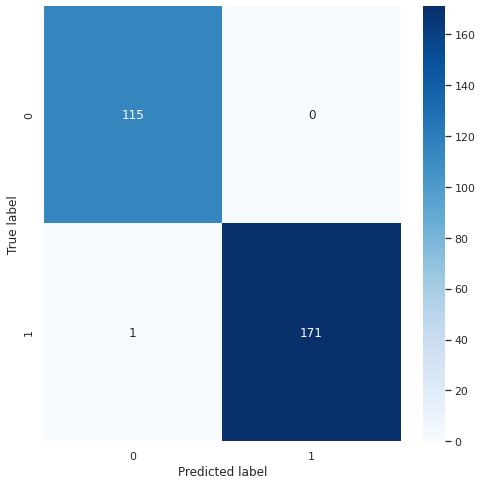

In [92]:
# build confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_tflite)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot = True, cmap = plt.cm.Blues, fmt = "d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [93]:
# overview on precision and recall .hdf5 model
class_names = ['Open', 'Close']
print(classification_report(y_test, y_pred, target_names = class_names))

              precision    recall  f1-score   support

        Open       0.99      1.00      1.00       115
       Close       1.00      0.99      1.00       172

    accuracy                           1.00       287
   macro avg       1.00      1.00      1.00       287
weighted avg       1.00      1.00      1.00       287



In [94]:
# overview on precision and recall .tflite model
class_names = ['Open', 'Close']
print(classification_report(y_test, y_pred_tflite, target_names = class_names))

              precision    recall  f1-score   support

        Open       0.99      1.00      1.00       115
       Close       1.00      0.99      1.00       172

    accuracy                           1.00       287
   macro avg       1.00      1.00      1.00       287
weighted avg       1.00      1.00      1.00       287



#STEP #12 - Visualize missclassified data

In [173]:
# Visualize the data that was missclassified from the testing set
i=0
imgs_fail_test=[]
while i < len(y_pred):
  if y_pred[i][0] is not (y_test[i][0] > 0.5):
    imgs_fail_test.append(i)
  i=i+1

print(imgs_fail_test)

[246]


True value:  [False]
Predicted value:  [ True]


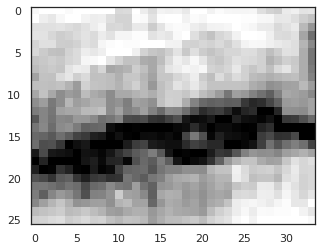

In [176]:
plt.imshow(X_test[246][:,:,-1], cmap='gray')
print('True value: ', y_pred[246])
print('Predicted value: ', y_test[246] > 0.5)

In [156]:
# Visualize the data that was missclassified from all data

i=0
imgs_fail=[]
while i < len(y_pred_all):
  if y_pred_all[i][0] is not (tgs[i][0] > 0.5):
     imgs_fail.append(i)
  i=i+1

print(imgs_fail)

[185, 1347, 2077, 2833]


True value:  [ True]
Predicted value:  [False]


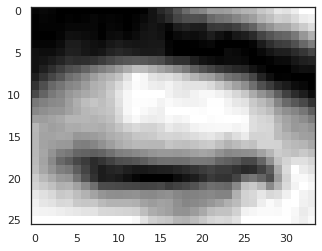

In [133]:
plt.imshow(imgs[185][:,:,-1], cmap='gray')
print('True value: ', y_pred_all[185])
print('Predicted value: ', tgs[185] > 0.5)

True value:  [ True]
Predicted value:  [False]


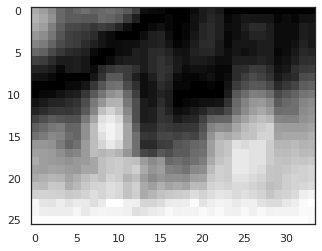

In [134]:
plt.imshow(imgs[1347][:,:,-1], cmap='gray')
print('True value: ', y_pred_all[1347])
print('Predicted value: ', tgs[1347] > 0.5)

True value:  [False]
Predicted value:  [ True]


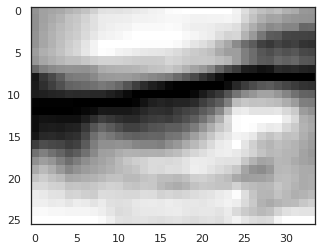

In [135]:
plt.imshow(imgs[2077][:,:,-1], cmap='gray')
print('True value: ', y_pred_all[2077])
print('Predicted value: ', tgs[2077] > 0.5)

True value:  [False]
Predicted value:  [ True]


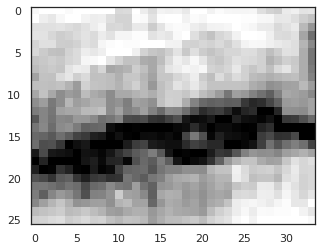

In [136]:
plt.imshow(imgs[2833][:,:,-1], cmap='gray')
print('True value: ', y_pred_all[2833])
print('Predicted value: ', tgs[2833] > 0.5)

#STEP #13 - Perform cross-validation

In [0]:
def build_model():

    # dimensions of the photos
    height = 26
    width = 34
    dims = 1

    loss_function = 'binary_crossentropy'
    learning_rate = 0.001

    model = Sequential()

    # first layer of convolution
    model.add(Conv2D(32, kernel_size=(3,3), padding = 'same', activation='relu', input_shape=(height, width, dims)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # second layer of convolution
    model.add(Conv2D(64, kernel_size=(3,3), padding= 'same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # third layer of convolution
    model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # drops some neurons along with their weights to avoid overfitting
    model.add(Dropout(0.25))

    model.add(Flatten())

    # first dense layer
    model.add(Dense(512))
    model.add(Activation('relu'))

    # second dense layer
    model.add(Dense(512))
    model.add(Activation('relu'))

    # output layer
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(optimizer = Adam(lr = learning_rate), loss = loss_function, metrics = ['accuracy'])

    return model

9/9 [==============================] - 0s 3ms/step - loss: 0.0375 - accuracy: 0.9861


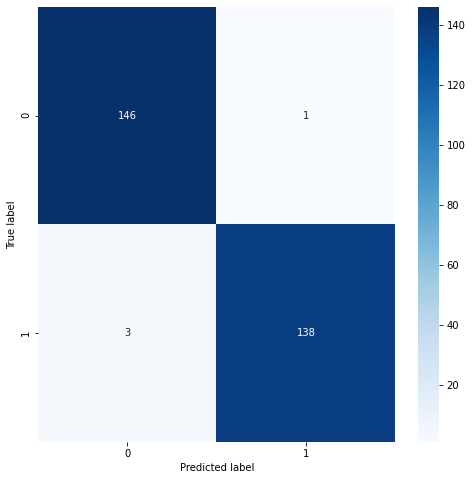

9/9 [==============================] - 0s 3ms/step - loss: 0.0473 - accuracy: 0.9826


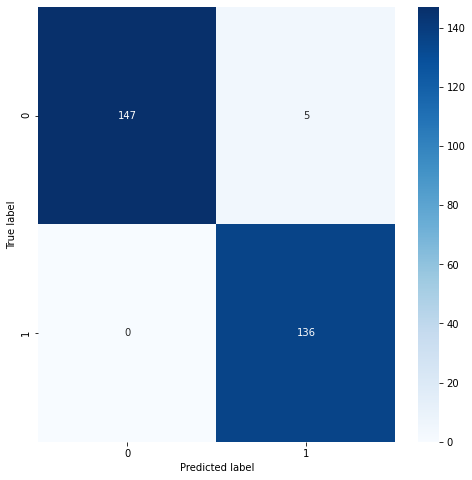

9/9 [==============================] - 0s 4ms/step - loss: 0.0138 - accuracy: 0.9965


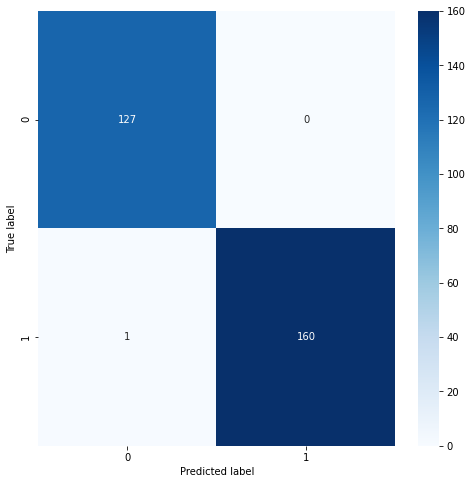

9/9 [==============================] - 0s 3ms/step - loss: 0.0097 - accuracy: 1.0000


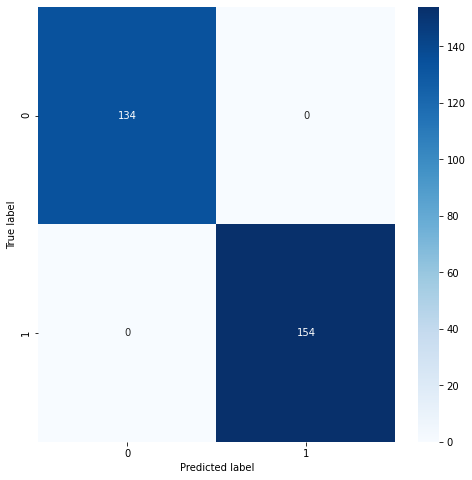

9/9 [==============================] - 0s 4ms/step - loss: 0.0188 - accuracy: 0.9965


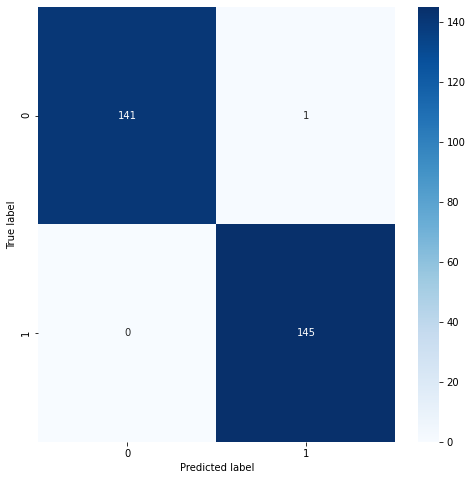

9/9 [==============================] - 0s 4ms/step - loss: 0.0075 - accuracy: 0.9965


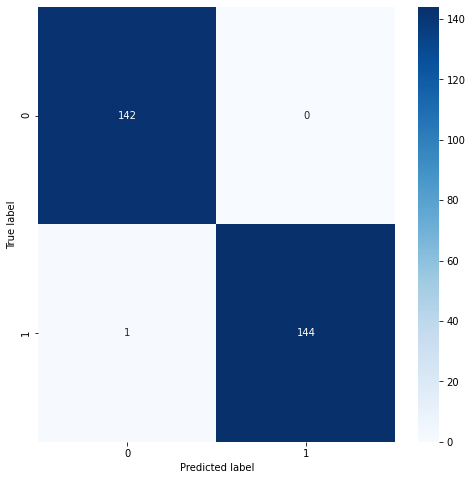

9/9 [==============================] - 0s 4ms/step - loss: 0.0295 - accuracy: 0.9965


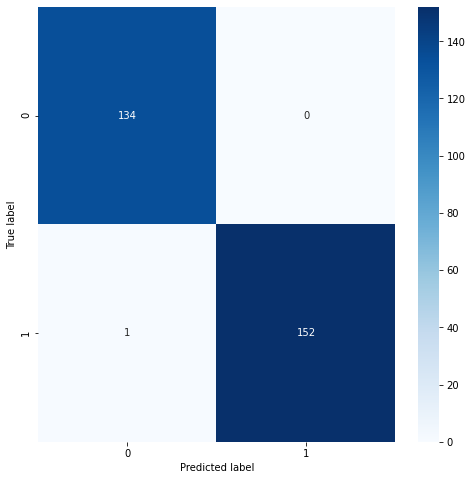

9/9 [==============================] - 0s 4ms/step - loss: 0.0290 - accuracy: 0.9861


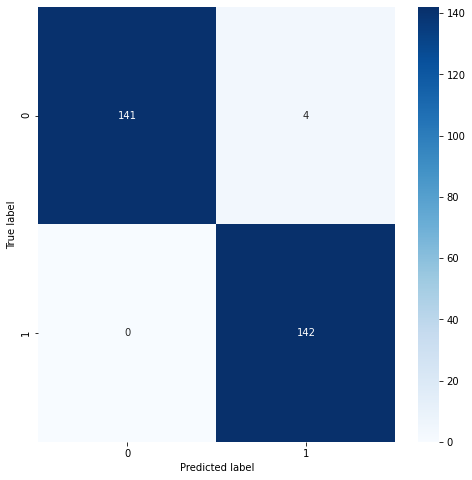

9/9 [==============================] - 0s 4ms/step - loss: 0.0016 - accuracy: 1.0000


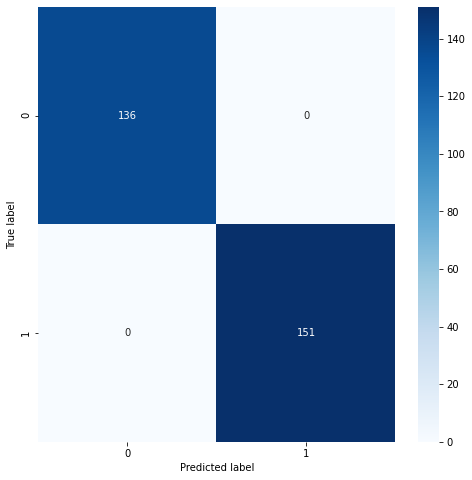

9/9 [==============================] - 0s 4ms/step - loss: 0.0258 - accuracy: 0.9861


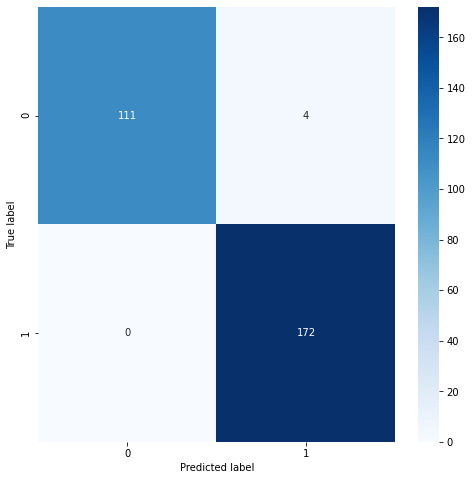

[0.9861111044883728, 0.9826388955116272, 0.9965277910232544, 1.0, 0.996515691280365, 0.996515691280365, 0.996515691280365, 0.9860627055168152, 1.0, 0.9860627055168152]


In [75]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

model = build_model()

# KFold Cross Validation approach
kf = KFold(n_splits=10, shuffle=False)
kf.split(imgs)    
     
# Initialize the accuracy and loss of the models to blank lists
accuracy = []
loss = []

# Initialize empty overall confusion matrix
overall_conf_matrix = np.matrix([[0,0],[0,0]])

# Initialize images vector for missclassified data
miss_imgs = []
 
# Iterate over each train-test split
for train_index, test_index in kf.split(imgs):
    
    # Split train-test
    X_train, X_test = imgs[train_index], imgs[test_index]
    y_train, y_test = tgs[train_index], tgs[test_index]
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Append to accuracy_model the accuracy of the model
    lss, acc = model.evaluate(X_test, y_test, batch_size = BATCH_SIZE, verbose = 1)
    accuracy.append(acc)
    loss.append(lss)

    # make prediction over test data
    y_pred = model.predict(X_test)

    # transform y_pred using threshold
    y_pred = (y_pred > 0.5)

    # Visualize the data that was missclassified from all data
    i=0
    while i < len(y_pred):
      if y_pred[i][0] is not (y_test[i][0] > 0.5):
        miss_imgs.append(X_test[i])
      i=i+1

    # Build and print confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, annot = True, cmap = plt.cm.Blues, fmt = "d")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 

    # Add current confision matrix to the overall confusion matrix
    overall_conf_matrix = overall_conf_matrix + conf_matrix

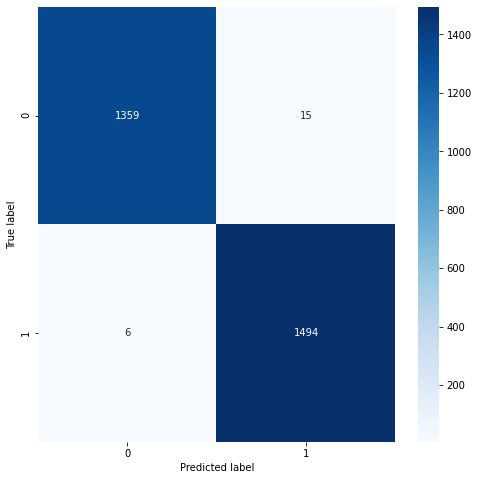

In [76]:
# Print overall confusion matrix

figure = plt.figure(figsize=(8, 8))
sns.heatmap(overall_conf_matrix, annot = True, cmap = plt.cm.Blues, fmt = "d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show() 

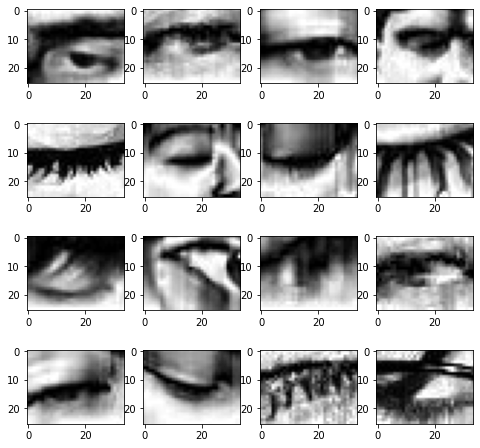

In [77]:
j = 0
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(miss_imgs[j][:,:,-1], cmap='gray')
    j=j+1
plt.show()

In [78]:
print(loss)
print(accuracy)

[0.03749360144138336, 0.04725799337029457, 0.013758134096860886, 0.009679894894361496, 0.01884845644235611, 0.0075218044221401215, 0.02952371910214424, 0.02902301773428917, 0.0016121178632602096, 0.025766467675566673]
[0.9861111044883728, 0.9826388955116272, 0.9965277910232544, 1.0, 0.996515691280365, 0.996515691280365, 0.996515691280365, 0.9860627055168152, 1.0, 0.9860627055168152]


In [79]:
# Visualize accuracy and loss for each iteration

import plotly.graph_objects as go
labels = ['Iter1','Iter2','Iter3','Iter4','Iter5','Iter6','Iter7','Iter8','Iter9','Iter10']

fig = go.Figure(data=[
    go.Bar(name='Accuracy', x=labels, y=accuracy),
    go.Bar(name='Loss', x=labels, y=loss)
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

In [80]:
# Visualize the accuracy changes over the 10 iterations

import plotly.graph_objects as go
import numpy as np

labels = ['Iter1','Iter2','Iter3','Iter4','Iter5','Iter6','Iter7','Iter8','Iter9','Iter10']
x = np.arange(10)

fig = go.Figure(data=go.Scatter(x=labels, y=accuracy))
fig.show()

In [81]:
# Visualize the loss changes over the 10 iterations

import plotly.graph_objects as go
import numpy as np

labels = ['Iter1','Iter2','Iter3','Iter4','Iter5','Iter6','Iter7','Iter8','Iter9','Iter10']
x = np.arange(10)

fig = go.Figure(data=go.Scatter(x=labels, y=loss))
fig.show()